# Introduction

This HDDM tutorial was written by Jae-Young Son ([email](jae@brown.edu), [web](www.jaeyoungson.com)) for the 2022 computational modeling workshop sponsored by the Carney Institute at Brown University. Please feel free to distribute these free and open materials to interested peers (yay, open science!), but kindly keep this attribution notice in place.

**Resources from the HDDM developers:**

The HDDM GitHub page can be found [here](https://github.com/hddm-devs/hddm).  
The [online documentation](https://hddm.readthedocs.io/en/latest/index.html) is as good as a textbook.  
If you need help, the [mailing list](https://groups.google.com/g/hddm-users) is very responsive.

**Resources from me:**

[This GitHub repository](https://github.com/psychNerdJae/hddm_tutorial) contains many self-teaching materials and resources that new users may find useful.

Here are some example of studies I've run using HDDM (with scripts):  
Manuscript: https://www.nature.com/articles/s41598-019-48050-2  
Data and scripts: https://osf.io/8ka47/

---

# Installation

There's a small amount of idiosyncratic setup needed to get Google Colab to work with HDDM, so let's do that now.

In [1]:
# These packages are not available to Google Colab by default,
# so we must install them ourselves
!pip install cython
!pip install pymc==2.3.8
!pip install git+https://github.com/hddm-devs/kabuki
!pip install git+https://github.com/hddm-devs/hddm

# Authorize this notebook to open files in your Google Drive.
# If you have multiple Google accounts (e.g., personal vs Brown accounts),
# make sure you're logged into the account where your data are stored!
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hddm-devs/kabuki to /tmp/pip-req-build-tq0il66z
  Running command git clone -q https://github.com/hddm-devs/kabuki /tmp/pip-req-build-tq0il66z
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hddm-devs/hddm to /tmp/pip-req-build-k7rnjtuy
  Running command git clone -q https://github.com/hddm-devs/hddm /tmp/pip-req-build-k7rnjtuy
  Running command git submodule update --init --recursive -q
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

# Set up environment

Let's now import all of the packages needed to run our analyses.

In [2]:
# If using a computing cluster, uncomment the following line & run before
# importing matplotlib.pyplot or pylab
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import hddm
import pandas as pd
import pickle
from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.analyze import post_pred_gen
from kabuki.utils import concat_models
import pathlib

There are a few things you'll want to manually change here, based on the dataset you're working with and where it lives.

In [3]:
# Point Google Colab to the right place in your Google Drive
basepath = '/content/drive/My Drive/Colab Notebooks/hddm_carney_2022'

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/models/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/results/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/plots/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/ppc/').mkdir(parents=True, exist_ok=True)

---

# Load data

Now, let's load some data. Note that at minimum, you need three columns in your CSV:

1. `subj_idx`: a unique numeric identifier for each subject
2. `response`: the subject's choice on a particular trial (`0`=lower boundary, `1`=upper boundary)
3. `rt`: the reaction time associated with the subject's choice

You will likely have more columns indicating different experimental manipulations, conditions, etc. Those can be named anything you want, but make sure to format your data in the same way you'd format data for mixed-effects regression models (i.e., one row corresponds to one trial, and each subject has undergone many trials).

In [4]:
# Load data from csv file
study3_data = hddm.load_csv(basepath+'/data/JustCon3_ddm_tutorial.csv')
study4_data = hddm.load_csv(basepath+'/data/JustCon4_ddm_tutorial.csv')

data = (
    # Combine dataframes
    pd.concat([study3_data, study4_data], ignore_index=True)
    # For tutorial purposes, only looking at one condition
    .query('offer == "unfair"')
    # Personal pet peeve
    .reset_index(drop=True)
)

# Check to make sure it's the data you expect/want
print(data.head(5))
print(data.tail(5))

   subj_idx  response        rt   study  phase   offer  rev_con rev_cat
0         1         0  1.599041  Victim  group  unfair      1.0     One
1         1         1  1.799143  Victim  group  unfair      4.0    Four
2         1         1  0.685874  Victim  group  unfair      4.0    Four
3         1         1  1.220541  Victim  group  unfair      4.0    Four
4         1         1  1.271272  Victim  group  unfair      3.0   Three
       subj_idx  response        rt  study  phase   offer  rev_con rev_cat
10652       345         1  0.466067  Juror  group  unfair      4.0    Four
10653       345         0  0.574509  Juror  group  unfair      2.0     Two
10654       345         0  0.463137  Juror  alone  unfair      NaN   Alone
10655       345         1  0.583683  Juror  group  unfair      4.0    Four
10656       345         0  0.318163  Juror  group  unfair      0.0    Zero


---

# Fitting a "vanilla" model

The simplest possible model is one in which we estimate the value of the main parameters (drift, threshold, non-decision time, and sometimes bias), which do not vary by condition. For the purpose of illustration, we'll try that out now.

In many cases, you won't need to estimate bias. It adds another layer of unnecessary computational complexity, and substantially slows down your sampling speed. However, given our task design (value-based decisions about social punishment), it is probably a good idea to do so.

As we can see, fitting the model is, in many ways, the easiest part of working with HDDM!

In [5]:
# For illustration, restrict to data where the participant was the victim, and
# was deciding by themselves (not in a group)
model_vanilla = hddm.HDDM(
    data.query('study == "Victim" & phase == "alone"'),
    bias=True
)

# Find a good starting point, which helps with convergence
model_vanilla.find_starting_values()

# Run the MCMC to get samples
model_vanilla.sample(5, burn=0)

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [--------------------120%---------------------] 6 of 5 complete in 3.6 sec

## Saving and loading models

Since it can take *quite* some time to run MCMC, we're not going to be running full-length chains to convergence – or else we'd be stuck here all day.

For the same reason, when you're running chains to convergence, you'll want to save the results of your computation. Otherwise, you'll have to rerun the models every time you want to do anything useful with HDDM... and that gets very frustrating and time-consuming.

You can save your models to disk using the template below.

In [6]:
model_vanilla = hddm.HDDM(
    data.query('study == "Victim" & phase == "alone"'),
    bias=True
)
model_vanilla.find_starting_values()

model_vanilla.sample(
    100,
    burn=0,
    dbname=basepath+'/models/vanilla_traces.db',
    db='pickle'
)
model_vanilla.save(basepath+'/models/vanilla_traces')

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 100 of 100 complete in 41.5 sec

Let's say that you want to open these traces back up later, and resume working with them in a new Python session. We can emulate doing this by deleting the object we just created.

First, we make sure that `model_vanilla` exists in memory...

In [7]:
"model_vanilla" in globals()

True

Now we delete it and make sure that it's gone...

In [8]:
del model_vanilla
"model_vanilla" in globals()

False

Finally, we load the traces back in, and resume working with the model.

Plotting v


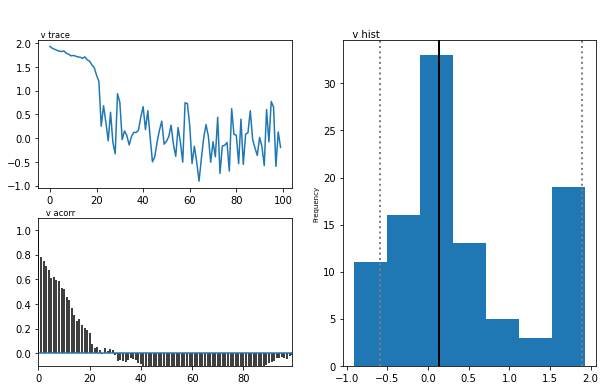

In [9]:
# Now load the model and plot one of the posteriors to make sure it worked
model_vanilla = hddm.load(basepath+'/models/vanilla_traces')
model_vanilla.plot_posteriors(['v'])

In the past, I've sometimes found that HDDM can be a little bit fussy about saving or loading models - but I'm a dinosaur who hasn't used the newest, shiniest versions of HDDM.

For personal reasons, I also prefer using R over Python for analysis. You can therefore export the model traces to a CSV, which you can subsequently open/analyze in any software. It also means that you can share the full model results with a collaborator who (for example) wants to analyze the data, but doesn't want to go through the trouble of installing HDDM. See below to see how.

**Pop quiz:** the CSV has 100 rows (not including the header). Why?

In [10]:
model_vanilla.get_traces().to_csv(basepath+'/results/vanilla_traces.csv')

## Visual convergence check

Every parameter in the model is estimated jointly with every other parameter in the model. Therefore, if even one parameter fails to converge, it prohibits us from examining any of the other parameters.

The fastest (but least reliable) method for checking convergence is to simply plot the posteriors. You want the the traceplot to look like a fuzzy caterpillar (why?), with no obvious trends over samples. You want the autocorrection to be as flat and close to 0 as possible (why?). Finally, you want the histogram to look approximately normal (why?).

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


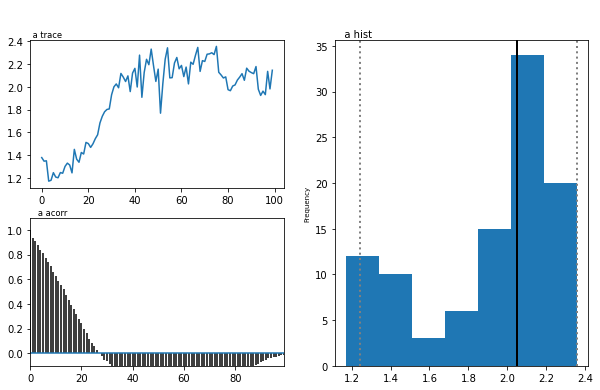

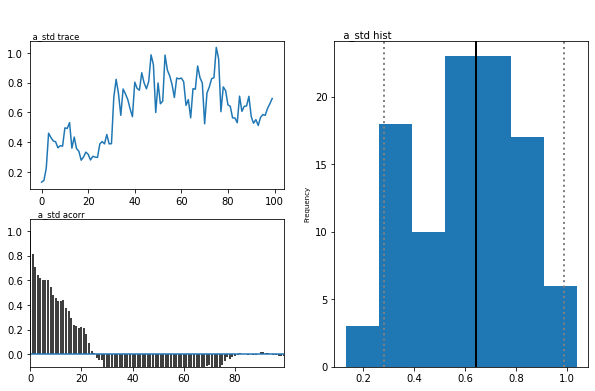

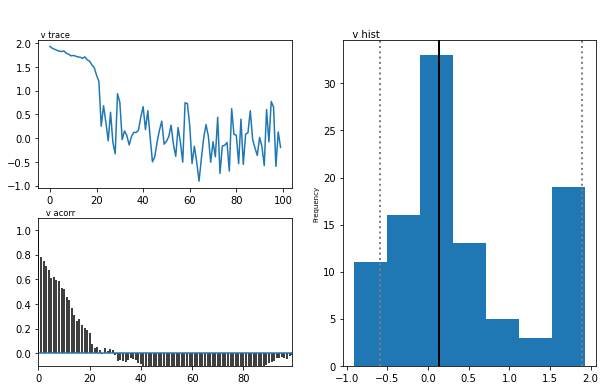

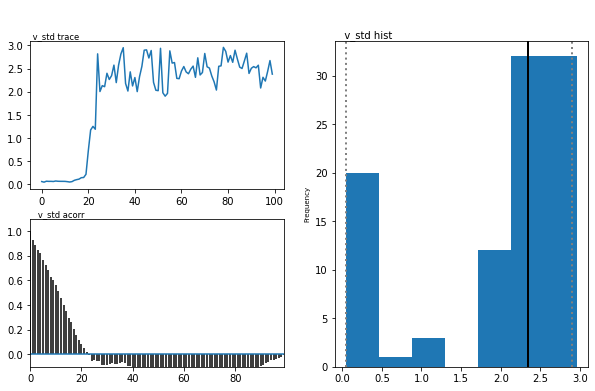

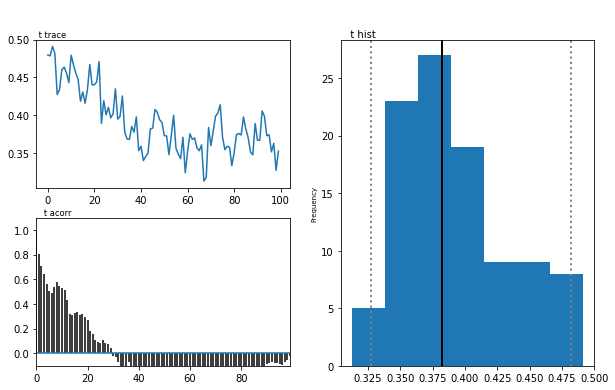

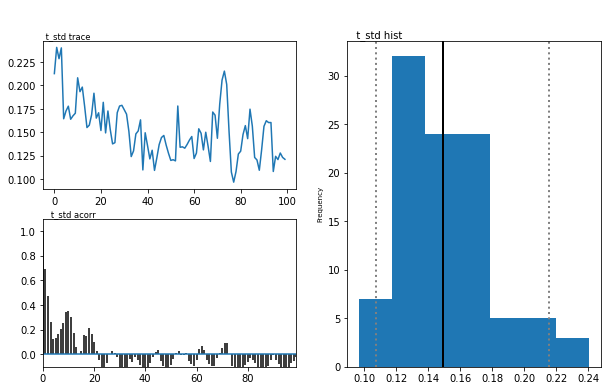

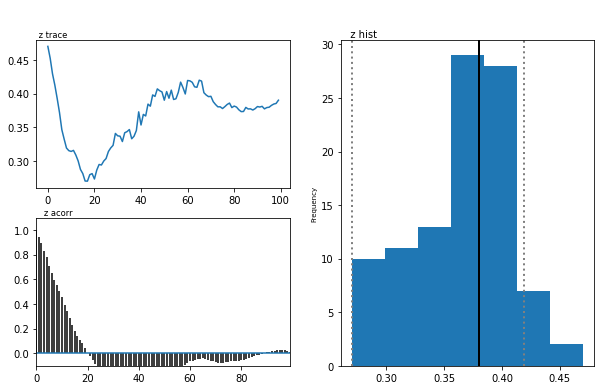

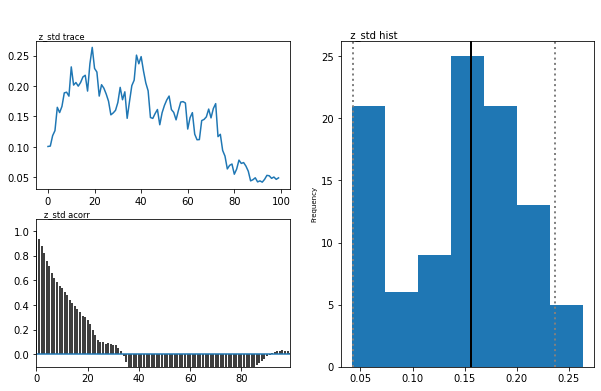

In [11]:
model_vanilla.plot_posteriors()

If you'd like, you can save whatever convergence plots you'd like as well.

Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v
Plotting v_std
Plotting a
Plotting a_std


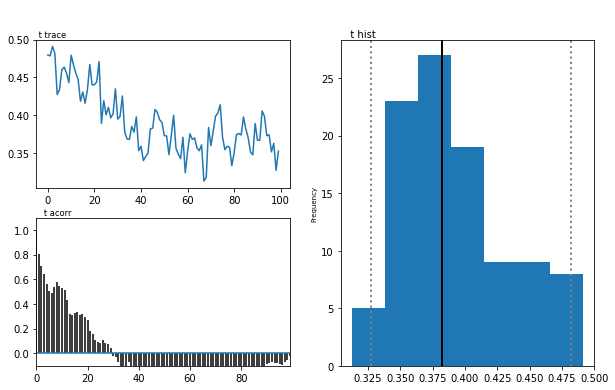

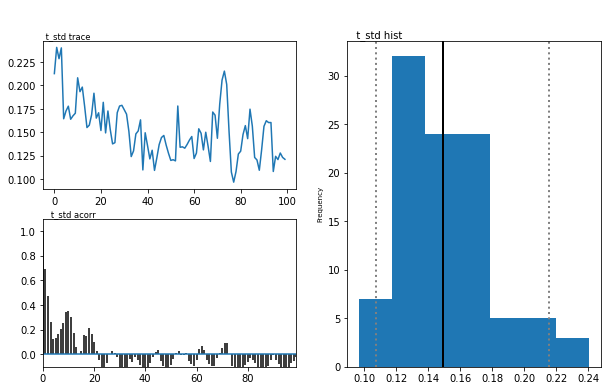

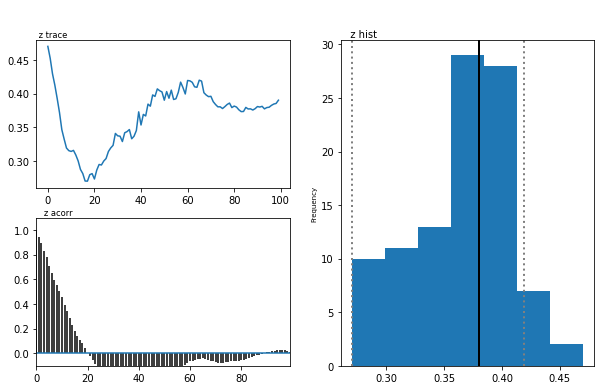

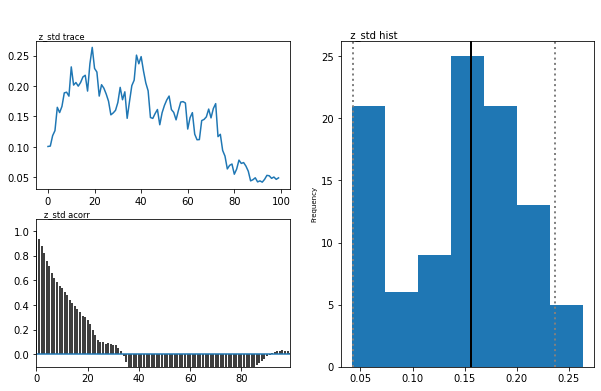

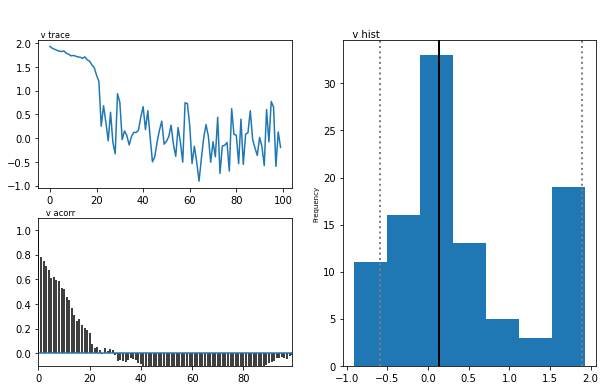

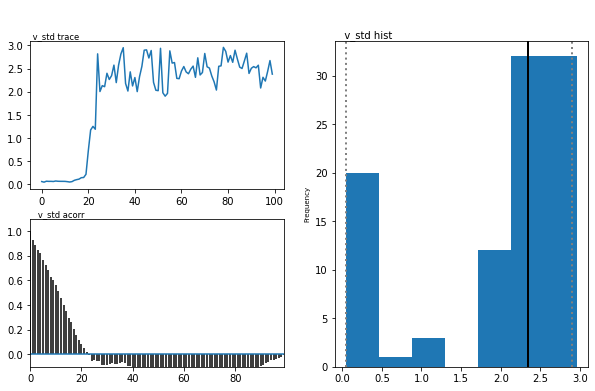

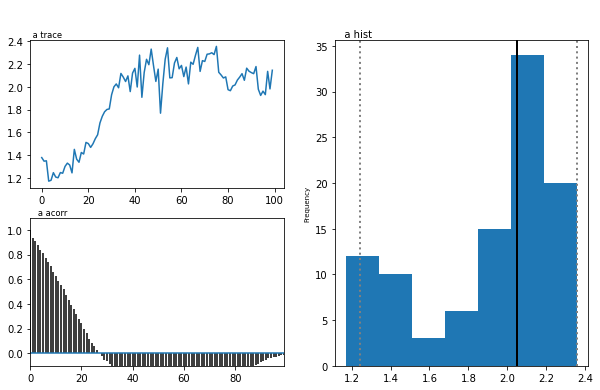

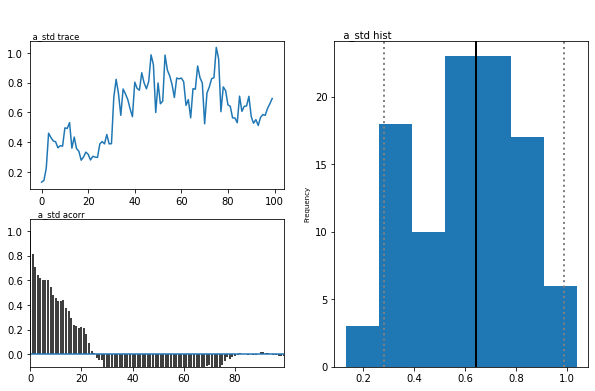

In [12]:
# Visual convergence check: list figures to be saved
# Change this according to what's in your model!
save_converge_plots = [
't', 't_std',
'z', 'z_std',
'v', 'v_std',
'a', 'a_std',
]

# Save convergence figures
for i in save_converge_plots:
  fig = model_vanilla.plot_posteriors(i)
  plt.savefig(basepath + '/plots/' + 'model_vanilla_' + i + '.pdf')

## A more formal convergence test

What is convergence? If we run many MCMCs, we want each chain to "settle" on the same answer. So, we need some statistic that will tell us to what degree each chain has converged onto the same answer.

The Gelman-Rubin statistic (also known as r-hat $\hat{R}$) is basically a ratio, which compares the amount of variance within a particular chain against the amount of variance in the other chains. If the ratio is close to `1`, that suggests that the variance is comparable across all chains, suggesting that all chains have converged onto the same answer.

As with the posterior plots, there will be a $\hat{R}$ statistic for every parameter estimated. Every single one must satisfy a criterion. [In 2012, Andrew Gelman suggested](https://www.tandfonline.com/doi/abs/10.1080/10618600.1998.10474787) a criterion of $\hat{R} < 1.2$, and I prefer to use $\hat{R} < 1.1$ in my own work. However, these thresholds are somewhat arbitrary; you will need to make some decisions about what values are acceptable to you.

In order to compute $\hat{R}$, we need to run multiple chains. Below, we can see an implementation where we run a `for` loop, since we don't have access to parallel processing on Google Colab. If you're running this on your university's computing cluster, you could try runnning a batch job (e.g., using job arrays on SLURM), where each job is one chain. That allows you to run all chains at the same time, in a pretty straightforward way.

As you look at the code below, ask yourself: how is this code similar to what we ran before? What is different?

In [13]:
# Initialize empty list
models_vanilla = []

for i in range(5):
  model_vanilla = hddm.HDDM(
      data.query('study == "Victim" & phase == "alone"'),
      bias=True
  )
  model_vanilla.find_starting_values()
  # To save time, keep the sample numbers absurdly low
  model_vanilla.sample(
      20, burn=0,
      dbname=basepath+'/models/vanilla_rhat'+'_%s.db'%i,
      db='pickle'
  )
  # Add the latest estimates to the list
  models_vanilla.append(model_vanilla)

# Save traces to CSV
(
    concat_models(models_vanilla)
    .get_traces()
    .to_csv(basepath+'/results/vanilla_rhat_traces.csv')
)

# Return the Gelman-Rubin statistics
gelman_rubin(models_vanilla)

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------105%------------------] 21 of 20 complete in 8.0 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------105%------------------] 21 of 20 complete in 8.8 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------105%------------------] 21 of 20 complete in 7.3 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------105%------------------] 21 of 20 complete in 7.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------105%------------------] 21 of 20 complete in 7.8 sec

{'a': 1.1050632199189556,
 'a_std': 1.121616234779502,
 'a_subj.1': 1.0947431449119764,
 'a_subj.10': 1.1246705676590198,
 'a_subj.11': 1.0285974603467016,
 'a_subj.12': 1.04790256307336,
 'a_subj.13': 1.1830383492156367,
 'a_subj.14': 1.101516893062414,
 'a_subj.15': 1.2643942737409697,
 'a_subj.16': 1.2788287764093198,
 'a_subj.17': 1.4585407359838458,
 'a_subj.18': 1.094267182465588,
 'a_subj.19': 1.0262696738349473,
 'a_subj.2': 1.0611946888018096,
 'a_subj.20': 0.976574527076268,
 'a_subj.21': 1.1692893159593378,
 'a_subj.22': 1.1187235184684277,
 'a_subj.23': 1.0093253158974016,
 'a_subj.24': 1.0192598371688637,
 'a_subj.25': 1.0233382164674358,
 'a_subj.26': 1.0433903328745187,
 'a_subj.27': 1.055079202927461,
 'a_subj.28': 1.0409293746618393,
 'a_subj.29': 1.1159352817338855,
 'a_subj.3': 1.079469061610078,
 'a_subj.30': 1.0773489399234235,
 'a_subj.31': 1.257047420030469,
 'a_subj.32': 1.2059100242838574,
 'a_subj.33': 1.0202254308885421,
 'a_subj.34': 1.1697191235674456,
 'a_

You can also save these statistics as a CSV, just to have readily on hand.

In [14]:
(
    pd.DataFrame.from_dict(gelman_rubin(models_vanilla), orient='index')
    .to_csv(basepath+'/results/vanilla_r_hat.csv')
)

## Hypothesis testing

In a Bayesian estimation framework, hypothesis testing is very straightforward. Since we have a posterior distribution, we can simply see what proportion of the posterior falls above (or below) some criterion of interest. If the proportion is greater than some criterion of interest (95% is often used to mimick the frequentist convention of $p < 0.05$), then we conclude that the parameter value is "significant."

In a vanilla model like this, we might simply want to test the hypothesis that the drift rate was less than `0`. If at least 95% of the traces are less than `0`, we'll consider our hypothesis supported.

***NOTE:*** You might be tempted to simply run a t-test on the traces, but it is generally NOT appropriate to subject the posteriors to frequentist tests. To learn more, check out John Kruschke's [BEST paper](https://pubmed.ncbi.nlm.nih.gov/22774788/) (Bayesian estimation supersedes the t-test).

***NOTE:*** It is not appropriate to perform hypothesis testing until we have checked for convergence. If the chain(s) have not converged, we cannot be confident in our parameter estimates, which means it is not appropriate to perform hypothesis testing on them.

In [15]:
# We can see all "nodes" (parameters) contained in the model
print(model_vanilla.nodes_db.node)

# We want to pull out the drift rate parameter
vanilla_v = model_vanilla.nodes_db.node['v']

a                  a
a_std          a_std
a_rate        a_rate
a_shape      a_shape
a_subj.1    a_subj.1
              ...   
wfpt.37      wfpt.37
wfpt.38      wfpt.38
wfpt.39      wfpt.39
wfpt.40      wfpt.40
wfpt.41      wfpt.41
Name: node, Length: 261, dtype: object


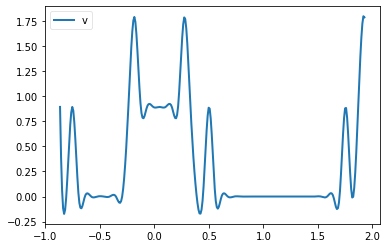

In [16]:
# Let's plot the posterior
hddm.analyze.plot_posterior_nodes([vanilla_v])

In [17]:
# What proportion of that posterior is greater than 0?

# We can see whether each of the traces is greater than 0
print(vanilla_v.trace() < 0)

# The mean of ^ will tell us the proportion
print((vanilla_v.trace() < 0).mean())

[False False False False False  True  True  True False  True False False
  True False False  True False False  True False]
0.35


---

# Multiple (between-subjects) conditions

Most of the time, we're interested in testing the effects of different conditions. This can be done with a simple extension of the syntax we've already covered/used. In this case, we'll compare parameter estimates for Victims versus Jurors.

In [18]:
model_conditions = hddm.HDDM(
    # Note that we're now including data from both victims and jurors
    data.query('phase == "alone"'),
    bias=True,
    # This part is new!
    # The column 'study' contains the values 'Victim' and 'Juror'
    # So separate drift rates will be estimated for victims/jurors
    depends_on={'v': 'study'}
)

model_conditions.find_starting_values()

model_conditions.sample(
    50,
    burn=0,
    dbname=basepath+'/models/conditions_traces.db',
    db='pickle'
)
model_conditions.save(basepath+'/models/conditions_traces')
model_conditions.get_traces().to_csv(basepath+'/results/conditions_traces.csv')

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------102%-----------------] 51 of 50 complete in 44.8 sec

As usual, you *must* check for convergence before hypothesis testing. We're going to skip this step for the sake of the tutorial, but remember that this is a critical and necessary part of statistical inference.

Let's take a look at what hypothesis testing might look like in this setup. We might have the hypothesis that Jurors have higher preference for punishment than Victims. (Does this sound counterintuitive? [Check out this paper by my PhD supervisor](https://www.nature.com/articles/ncomms6306) if you're interested in learning more about the topic!)

0.66


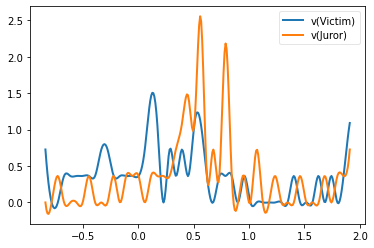

In [19]:
# Pull out the drift rate parameters
conditions_v_victim = model_conditions.nodes_db.node['v(Victim)']
conditions_v_juror = model_conditions.nodes_db.node['v(Juror)']

# Plot posteriors
hddm.analyze.plot_posterior_nodes([conditions_v_victim, conditions_v_juror])

# Test hypothesis
print(
    (conditions_v_victim.trace() < conditions_v_juror.trace()).mean()
)

---

# Regression (within-subject)

Regression is my favorite part of using HDDM, and the reason why I anticipate HDDM being the gold standard software for many years to come.

The downsides of using the `depends_on` syntax in vanilla HDDM are:

1. Only works if you have discrete conditions. What if you had trial-by-trial manipulations or biological measures that you want to analyze?

2. If you have within-subject conditions, using `depends_on` is conceptually the same as running X separate models for X conditions. Therefore, you lose all of the benefits of running a within-subject study.

In the context of my study, I might hypothesize that groups provide stronger evidence for punishment's value when there are increasingly large majorities who endorse punishment. Not too controversial, I think. Since we have a condition where participants are choosing alone, let's use that as the "reference category" against which we'll compare other conditions.

In [20]:
model_regression = hddm.HDDMRegressor(
    # For tutorial, only looking at victim data
    data.query('study == "Victim" & offer == "unfair"'),
    # Define regression models of arbitrary complexity, for any parameter
    {"v ~ C(rev_cat, Treatment('Alone'))",
     "a ~ C(rev_cat, Treatment('Alone'))"},
     group_only_regressors=True,
     p_outlier=.05,
     include={'z'}
)

model_regression.find_starting_values()

model_regression.sample(
    10,
    burn=0,
    dbname=basepath+'/models/regression_traces.db',
    db='pickle'
)
model_regression.save(basepath+'/models/regression_traces')
model_regression.get_traces().to_csv(basepath+'/results/regression_traces.csv')

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [------------------110%-------------------] 11 of 10 complete in 69.2 sec

Although you need to perform convergence checks before interpreting results, we're again skipping those for the sake of time.

We can do a quick set of hypothesis tests, as usual.

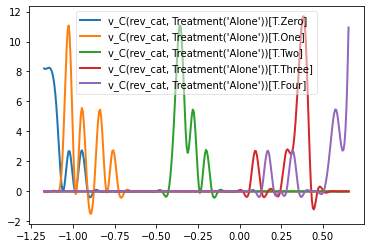

In [21]:
regression_v_0 = model_regression.nodes_db.node[
    'v_C(rev_cat, Treatment(\'Alone\'))[T.Zero]'
]
regression_v_1 = model_regression.nodes_db.node[
    'v_C(rev_cat, Treatment(\'Alone\'))[T.One]'
]
regression_v_2 = model_regression.nodes_db.node[
    'v_C(rev_cat, Treatment(\'Alone\'))[T.Two]'
]
regression_v_3 = model_regression.nodes_db.node[
    'v_C(rev_cat, Treatment(\'Alone\'))[T.Three]'
]
regression_v_4 = model_regression.nodes_db.node[
    'v_C(rev_cat, Treatment(\'Alone\'))[T.Four]'
]

# Plot posteriors
hddm.analyze.plot_posterior_nodes(
    [
     regression_v_0,
     regression_v_1,
     regression_v_2,
     regression_v_3,
     regression_v_4
    ]
)

In [22]:
# Test hypothesis that drift rate is stronger when 4/4 group members endorse
# punishment, compared to when choosing alone
print(
    (regression_v_4.trace() > 0).mean()
)

1.0


In [23]:
# Test hypothesis that drift rate is stronger when 4/4 group members endorse
# punishment, compared to when 0/4 group members endorse punishment
print(
    (regression_v_0.trace() < regression_v_4.trace()).mean()
)

1.0


## Model comparison

Our regression model specification was fairly complex. Does it outperform a simpler model? Are there other regression models that can test alternative hypotheses?

This is where model comparison comes in play. Trivially, we need at least two models to compare, so let's estimate a less complex regression model where only the drift rate is modulated by a predictor.

In [24]:
model_comparison = hddm.HDDMRegressor(
    # For tutorial, only looking at victim data
    data.query('study == "Victim" & offer == "unfair"'),
    # Get rid of threshold regression
    {"v ~ C(rev_cat, Treatment('Alone'))"},
     group_only_regressors=True,
     p_outlier=.05,
     include={'z'}
)

model_comparison.find_starting_values()

model_comparison.sample(
    10,
    burn=0,
    dbname=basepath+'/models/comparison_traces.db',
    db='pickle'
)
model_comparison.save(basepath+'/models/comparison_traces')
model_comparison.get_traces().to_csv(basepath+'/results/comparison_traces.csv')

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [------------------110%-------------------] 11 of 10 complete in 32.1 sec

The simplest heuristic we can use is DIC, a model fit statistic similar to AIC/BIC, but appropriate for hierarchical models like the ones we're estimating. Like AIC/BIC, lower numbers indicate better fit. Like BIC, this statistic penalizes for model complexity.

In [25]:
# Get DICs
print("DIC: %f" %model_regression.dic)
print("DIC: %f" %model_comparison.dic)

DIC: 6691.667513
DIC: 6478.162842


Of course, there's a lot that isn't communicated by a single statistic... This is where posterior predictive checks can come in handy, as they might illuminate how the model is systematically mischaracterizing your data. Even if a particular model isn't doing the "best" job of minimizing overall error (has higher DIC), it might still be capturing patterns in your data that are being missed by the "better" model.

## Posterior predictive check

PPCs can (and should) be performed for any class of HDDM models, but we'll focus our attention on what they look like in regression models. Basically, we want to compare the predictions made by our model (given the parameter fits), and compare them against our empirical data.

For an example of what this might look like, look at the [Supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-019-48050-2/MediaObjects/41598_2019_48050_MOESM1_ESM.docx) for the Crowdsourcing Punishment paper, particularly Figures S7 and S9. The PPC revealed systematic mismatches between the model predictions and the actual data, which we needed to explain. From the supplement:

> The PPC reveals one particularly noteworthy pattern: The Victim model’s predictions least faithfully capture the observed RT distribution for Reverse decisions in the condition where offers are Mildly Unfair and the group unanimously prefers Compensation (i.e., 0% endorsement of punishment). We believe that the mismatch between the model prediction and observed data is an artifact of the Bayesian hierarchical fitting process. That is, if a minority of subjects were using a different decision strategy from the rest of the group, the hierarchical model would down-weight those subjects’ contributions to the group posterior. Therefore, if the majority of Reverse responses in specific conditions came from that minority group, we would expect to observe a discrepancy in RT distributions between the observed data (primarily composed of responses from the minority group) and the simulated data (relying more heavily on the group prior after discounting the contributions of the minority group).

This inspired us to do further data checks, the result of which is summarized in the supplement and visualized in Figure S8.

In [26]:
# Generate predicted results from previously-estimated models
# Normally, we'd want to get many, many samples - I've done 1000 in the past
# But, for the sake of time, let's just do a couple
(
    post_pred_gen(model_regression, samples=2, append_data=True)
    .to_csv(basepath+'/ppc/regression_ppc.csv')
)

 [-----------------100%-----------------] 41 of 41 complete in 1.5 sec

Let's take a look at what that CSV looks like... Note that this produces a "carbon copy" of your dataset, times the number of samples you generate.

## Continuous regression

Note that HDDM can also perform regression for continuous covariates, not just categorical ones. In the context of this study, we might want to know how strongly drift rate and threshold increase as the number of punishers increases.

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [------------------110%-------------------] 11 of 10 complete in 29.5 sec

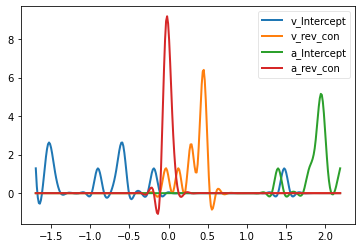

In [27]:
model_regression_continuous = hddm.HDDMRegressor(
    # For tutorial, only looking at victim data
    data.query('study == "Victim" & offer == "unfair" & rev_cat != "Alone"'),
    # Define regression models of arbitrary complexity, for any parameter
    {"v ~ rev_con",
     "a ~ rev_con"},
     group_only_regressors=True,
     p_outlier=.05,
     include={'z'}
)

model_regression_continuous.find_starting_values()

model_regression_continuous.sample(
    10,
    burn=0,
    dbname=basepath+'/models/regression_continuous_traces.db',
    db='pickle'
)
model_regression_continuous.save(
    basepath+'/models/regression_continuous_traces'
)
model_regression_continuous.get_traces().to_csv(
    basepath+'/results/regression_continuous_traces.csv'
)

# Plot posteriors
hddm.analyze.plot_posterior_nodes(
    [
        model_regression_continuous.nodes_db.node['v_Intercept'],
        model_regression_continuous.nodes_db.node['v_rev_con'],
        model_regression_continuous.nodes_db.node['a_Intercept'],
        model_regression_continuous.nodes_db.node['a_rev_con']
    ]
)

---

# Parameter recovery

Depending on your task and how participants respond to it, you might end up estimating values from "weird" parts of parameter space. Even if multiple chains converge on the (more-or-less) same parameter values, those values might not be totally identifiable.

Even harder to diagnose are cases when a particular *combination* of parameter estimates is un-identifiable.

So, you want to make sure that HDDM is capable of recovering (accurately estimating) a set of "ground truth" parameters.

## Simulate data

So, you've estimated some parameters from real data. Let's say that you've found the "true" parameters. If you were to run many more experiments, where the true parameter values remain the same, how reliably can you estimate those parameters in those new experiments?

To answer this, we're going to simulate data based on the parameters estimated from real data.

In [28]:
# Number of subjects matches that of the actual experiment
# For the number of trials per condition, you should run this twice:
#   Once with a small number of trials (or, the number of trials in your study),
#     which lets you know whether HDDM can reliably estimate the parameters
#     given the amount of data you originally fed it
#   Once with a larger number of trials, which lets you know whether HDDM can
#     reliably estimate the parameters as the amount of data used to inform the
#     computation approaches infinity
num_subs = 40
trials_per_cond = 20

# Drift rate estimates (empirical)
v_A = -0.2006909
v_0 = v_A + -0.7693828
v_1 = v_A + -0.6429486
v_2 = v_A + -0.1640435
v_3 = v_A + 0.4457329
v_4 = v_A + 0.6793762

# Threshold estimates
a_A = 2.1356529
a_0 = a_A + -0.1365446
a_1 = a_A + -0.1131092
a_2 = a_A + 0.0615770
a_3 = a_A + -0.0230197
a_4 = a_A + -0.1731338

# Bias and nondecision time estimates
z = 0.4410610
t = 0.3206254

# Define each condition and its corresponding parameters
params = {
    'rev_A': {'a':a_A, 't':t, 'v':v_A, 'z':z},
    'rev_0': {'a':a_0, 't':t, 'v':v_0, 'z':z},
    'rev_1': {'a':a_1, 't':t, 'v':v_1, 'z':z},
    'rev_2': {'a':a_2, 't':t, 'v':v_2, 'z':z},
    'rev_3': {'a':a_3, 't':t, 'v':v_3, 'z':z},
    'rev_4': {'a':a_4, 't':t, 'v':v_4, 'z':z}
}

# Now simulate that data
sim_data, sim_params = hddm.generate.gen_rand_data(
    params,
    size=trials_per_cond,
    subjs=num_subs,
    subj_noise=.1
)

## Estimate parameters from simulated data

Literally just copy/paste the regression model you used to estimate parameters.

The point of doing this analysis is to make sure that the combination of parameters you estimated from the empirical data are parameters that HDDM is capable of reliably estimating.

So given that we know exactly what the expected parameter values are (since we simulated them), can HDDM then take that simulated data and give us an estimate that's in the right ballpark?

In [29]:
# Initialize empty list
models_recovery = []

for i in range(5):
  model_recovery = hddm.HDDMRegressor(
      sim_data,
      {"v ~ C(condition, Treatment('rev_A'))",
       "a ~ C(condition, Treatment('rev_A'))"},
       group_only_regressors=True,
       p_outlier=.05,
       include={'z'})
  model_recovery.find_starting_values()

  # To save time, keep the sample numbers low
  model_recovery.sample(
      5, burn=0,
      dbname=basepath+'/models/recovery_traces'+'_%s.db'%i,
      db='pickle'
  )
  model_recovery.save(basepath+'/models/recovery_traces_%s'%i)

  # Add the latest estimates to the list
  models_recovery.append(model_recovery)

No model attribute --> setting up standard HDDM
Set model to ddm


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [--------------------120%---------------------] 6 of 5 complete in 53.6 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [--------------------120%---------------------] 6 of 5 complete in 54.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [--------------------120%---------------------] 6 of 5 complete in 57.1 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [--------------------120%---------------------] 6 of 5 complete in 60.2 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [--------------------120%---------------------] 6 of 5 complete in 50.8 sec

In [30]:
# Save traces to CSV
(
    model_recovery
    .get_traces()
    .to_csv(basepath+'/results/recovery_traces.csv')
)

# Calculate Gelman-Rubin r-hat statistic
(
    pd.DataFrame.from_dict(gelman_rubin(models_recovery), orient='index')
    .to_csv(basepath+'/results/recovery_r_hat.csv')
)

## Then what?

At the very least, you want to ensure that the "true" parameter value (the one you used to simulate data) is within the Bayesian High Density Interval (HDI) corresponding to some credible interval of your choosing (95% often gets used by convention).

If your known parameter value falls outside the HDI, then there's evidence that your parameters are drawn from a weird part of parameter space. This would be a good sign that you need to go back into your (regression) models and diagnose what's causing the weirdness.

# Reproducibility

This code was run on Google Colab in August 2022, using the following version of HDDM.

In [31]:
print(hddm.__version__)

0.9.7
